In [1]:
import numpy as np
import matplotlib.pyplot as plt

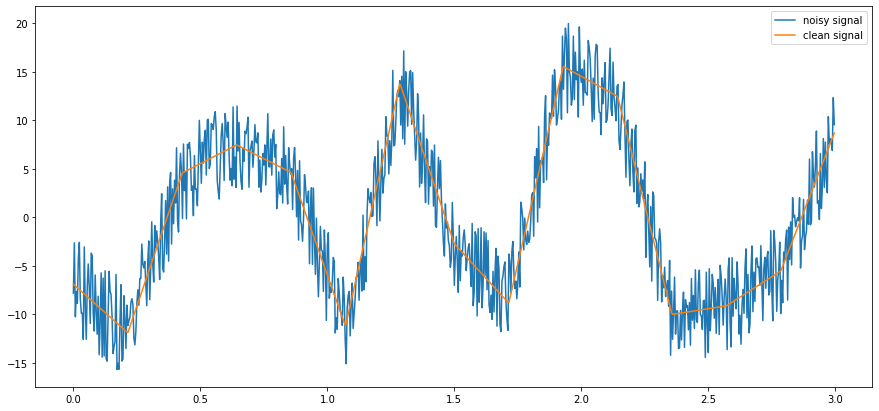

In [2]:
# Creating signal

sampling_rate = 256
time = np.arange(0, 3, 1 / sampling_rate)  # 256 * 3 seconds
n_interpolation_pole = 15  # real number of data points before interpolation
n_data = len(time)  # number of data points after interpolation
data_amplitude = 30
noise_amplitude = 5

clean_signal = np.random.random(n_interpolation_pole) * data_amplitude
clean_signal = np.interp(time, np.linspace(0, 3, n_interpolation_pole), clean_signal)
noise = np.random.uniform(-1, 1, n_data) * noise_amplitude
noisy_signal = clean_signal + noise
# Subtract mean to eliminate DC
noisy_signal -= np.mean(noisy_signal)

plt.figure(figsize=(15, 7))
plt.plot(time, noisy_signal, label='noisy signal')
plt.plot(time, clean_signal-np.mean(clean_signal), label='clean signal')
plt.legend()


c:\users\neural_creator\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


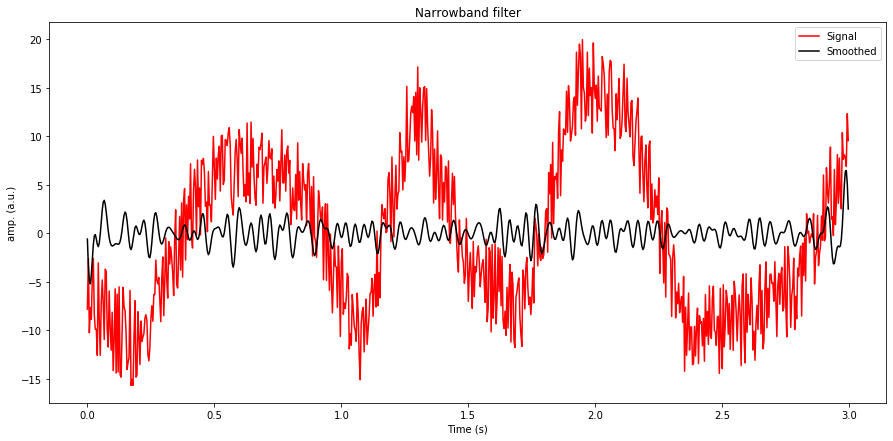

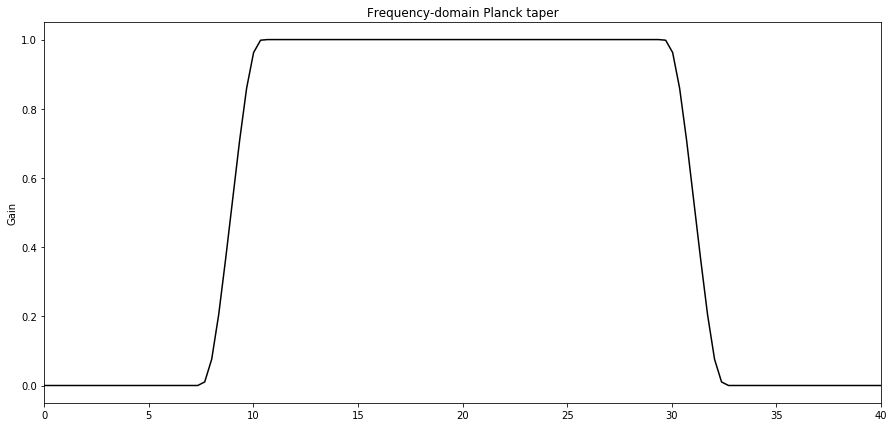

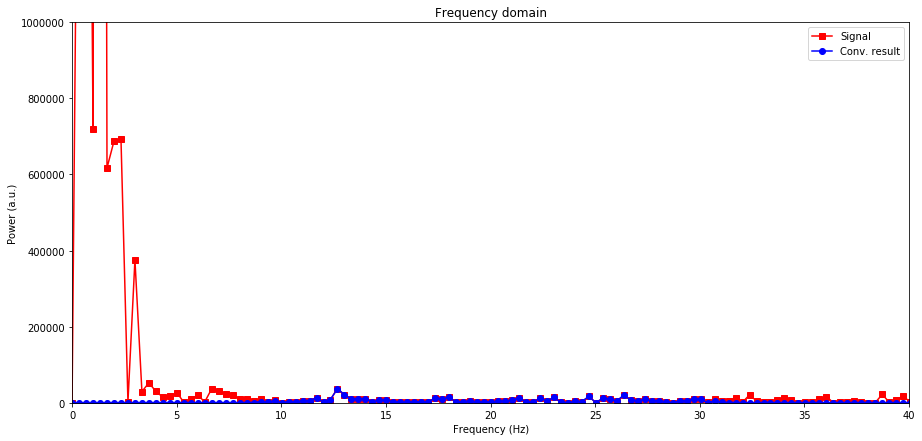

In [8]:
## create Planck spectral shape

# frequencies
hz = np.linspace(0, sampling_rate, n_data)

# edge decay, must be between 0 and .5
eta = .15

# spectral parameters. The band pass would be in range [peak_frequency-fwhm; peak_frequency-fwhm]
fwhm = 13
peak_frequency = 20

# convert fwhm to indices
mp = np.round(2 * fwhm * n_data / sampling_rate)  # in MATLAB this is np, but np=numpy
pt = np.arange(1, mp + 1)

# find center point index
fidx = np.argmin((hz - peak_frequency) ** 2)

# define left and right exponentials
Zl = eta * (mp - 1) * (1 / pt + 1 / (pt - eta * (mp - 1)))
Zr = eta * (mp - 1) * (1 / (mp - 1 - pt) + 1 / ((1 - eta) * (mp - 1) - pt))

# create the taper
offset = mp % 2
bounds = [np.floor(eta * (mp - 1)) - offset, np.ceil((1 - eta) * (mp - (1 - offset)))]
plancktaper = np.concatenate((1 / (np.exp(Zl[range(0, int(bounds[0]))]) + 1), np.ones(int(np.diff(bounds) + 1)),
                              1 / (np.exp(Zr[range(int(bounds[1]), len(Zr) - 1)]) + 1)), axis=0)

# put the taper inside zeros
px = np.zeros(len(hz))
pidx = range(int(np.max((0, fidx - np.floor(mp / 2) + 1))), int(fidx + np.floor(mp / 2) - mp % 2 + 1))
px[np.round(pidx)] = plancktaper

## now for convolution

# FFTs
dataX = np.fft.fft(noisy_signal)

# IFFT
convres = 2 * np.real(np.fft.ifft(dataX * px))

# frequencies vector
hz = np.linspace(0, sampling_rate, n_data)

### time-domain plots

# lines
plt.figure(figsize=(15, 7))
plt.plot(time, noisy_signal, 'r', label='Signal')
plt.plot(time, convres, 'k', label='Smoothed')
plt.xlabel('Time (s)'), plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Narrowband filter')
plt.show()

### frequency-domain plot

# plot Planck kernel
plt.figure(figsize=(15, 7))
plt.plot(hz, px, 'k')
plt.xlim([0, peak_frequency * 2])
plt.ylabel('Gain')
plt.title('Frequency-domain Planck taper')
plt.show()

# raw and filtered data spectra
plt.figure(figsize=(15, 7))
plt.plot(hz, np.abs(dataX)**2, 'rs-', label='Signal')
plt.plot(hz, np.abs(dataX * px)**2, 'bo-', label='Conv. result')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (a.u.)')
plt.legend()
plt.title('Frequency domain')
plt.xlim([0, peak_frequency * 2])
plt.ylim([0, 1e6])
plt.show()
